In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from tqdm import tqdm
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

# **DATA PREPARATION AND AUGMENTATION**

In [7]:
class DataProcessor:
    """Class to handle data loading, preprocessing and augmentation."""

    def __init__(self, data_path, img_size=(128, 128), validation_split=0.2, batch_size=32):
        """
        Initialize the data processor.

        Args:
            data_path: Path to the dataset directory
            img_size: Target image size (height, width)
            validation_split: Fraction of data to use for validation
            batch_size: Batch size for training
        """
        self.data_path = data_path
        self.img_size = img_size
        self.validation_split = validation_split
        self.batch_size = batch_size
        self.classes = None

    def load_raw_data(self):
        """Load raw data from directories."""
        print("Loading data from", self.data_path)
        self.classes = os.listdir(self.data_path)
        print(f"Found {len(self.classes)} classes: {self.classes}")

        train_data = []

        for i, class_name in enumerate(self.classes):
            path = os.path.join(self.data_path, class_name)
            print(f"Loading class {i}: {class_name}")

            for img in tqdm(os.listdir(path)):
                try:
                    img_arr = cv2.imread(os.path.join(path, img))
                    if img_arr is None:
                        print(f"Warning: Could not read image {img}")
                        continue
                    img_arr = cv2.resize(img_arr, self.img_size)
                    train_data.append([img_arr, i])
                except Exception as e:
                    print(f"Error processing {img}: {str(e)}")

        print(f"Total images loaded: {len(train_data)}")
        random.shuffle(train_data)

        # Split into images and labels
        train_imgs = []
        train_labels = []

        for img, label in train_data:
            train_imgs.append(img)
            train_labels.append(label)

        train_imgs_np = np.array(train_imgs)
        train_labels_np = np.array(train_labels)

        print(f"Data shape: {train_imgs_np.shape}, Labels shape: {train_labels_np.shape}")

        # Normalize pixel values
        train_imgs_np = train_imgs_np / 255.0

        return train_imgs_np, train_labels_np

    def create_data_generators(self, x_train, y_train):
        """Create training and validation data generators with augmentation."""
        # First, shuffle the data to ensure classes are well distributed
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Check class distribution
        unique_classes, counts = np.unique(y_train, return_counts=True)
        print(f"Class distribution: {dict(zip(unique_classes, counts))}")

        # Ensure minimum samples per class (at least 2 for validation split to work)
        min_samples = min(counts)
        if min_samples < 5:  # arbitrary threshold to ensure enough samples for both splits
            print(f"Warning: Some classes have very few samples ({min_samples}). This might cause issues with validation splits.")
            print("Consider adding more samples or using a smaller validation_split.")

        # Create the data generator for augmentation
        datagen = ImageDataGenerator(
            # Randomly shift images horizontally
            width_shift_range=0.2,
            # Randomly shift images vertically
            height_shift_range=0.2,
            # Randomly flip images horizontally
            horizontal_flip=True,
            # Randomly rotate images
            rotation_range=20,
            # Randomly zoom images
            zoom_range=0.2,
            # Randomly change brightness
            brightness_range=[0.8, 1.2],
            # Validation split
            validation_split=self.validation_split
        )

        # Manually split the data to ensure class representation
        # Alternative to using validation_split in ImageDataGenerator
        split_idx = int(len(x_train) * (1 - self.validation_split))
        x_train_split, x_val_split = x_train[:split_idx], x_train[split_idx:]
        y_train_split, y_val_split = y_train[:split_idx], y_train[split_idx:]

        # Check if all classes are represented in both splits
        train_classes = np.unique(y_train_split)
        val_classes = np.unique(y_val_split)

        if len(train_classes) != len(val_classes):
            print("Warning: Training and validation sets have different number of classes.")
            print(f"Training classes: {train_classes}")
            print(f"Validation classes: {val_classes}")
            print("Adjusting split to ensure all classes are represented...")

            # Create a new split ensuring all classes are represented
            # This is a simple approach - more sophisticated stratification might be needed
            x_train_final, x_val_final = [], []
            y_train_final, y_val_final = [], []

            for cls in unique_classes:
                # Get indices for this class
                cls_indices = np.where(y_train == cls)[0]
                cls_count = len(cls_indices)
                # Ensure at least one sample in validation
                val_count = max(1, int(cls_count * self.validation_split))
                train_count = cls_count - val_count

                # Split indices for this class
                train_indices = cls_indices[:train_count]
                val_indices = cls_indices[train_count:]

                # Add to final datasets
                x_train_final.extend(x_train[train_indices])
                y_train_final.extend(y_train[train_indices])
                x_val_final.extend(x_train[val_indices])
                y_val_final.extend(y_train[val_indices])

            # Convert to numpy arrays
            x_train_split = np.array(x_train_final)
            y_train_split = np.array(y_train_final)
            x_val_split = np.array(x_val_final)
            y_val_split = np.array(y_val_final)

            print(f"Adjusted split - Training: {len(x_train_split)}, Validation: {len(x_val_split)}")

        # Create training generator
        train_generator = datagen.flow(
            x_train_split, y_train_split,
            batch_size=self.batch_size
        )

        # Create validation generator - using same datagen but with no augmentation
        # for consistent validation
        validation_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation
        validation_generator = validation_datagen.flow(
            x_val_split, y_val_split,
            batch_size=self.batch_size
        )

        return train_generator, validation_generator

    def visualize_augmentations(self, x_train, n_images=5):
        """Visualize data augmentation examples."""
        datagen = ImageDataGenerator(
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            rotation_range=20,
            zoom_range=0.2,
            brightness_range=[0.8, 1.2]
        )

        # Get a sample image
        sample_image = x_train[0]
        sample_image = np.expand_dims(sample_image, 0)

        # Create a plot
        plt.figure(figsize=(15, 3))
        plt.subplot(1, n_images+1, 1)
        plt.title("Original")
        plt.imshow(sample_image[0])
        plt.axis('off')

        # Generate and plot augmented images
        aug_iter = datagen.flow(sample_image)
        for i in range(n_images):
            plt.subplot(1, n_images+1, i+2)
            plt.title(f"Augmented {i+1}")
            plt.imshow(next(aug_iter)[0])
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# **MODEL DEFINITION**

In [8]:
class ModelBuilder:
    """Class to handle model creation and training."""

    def __init__(self, input_shape, num_classes, learning_rate=0.001):
        """
        Initialize the model builder.

        Args:
            input_shape: Shape of input images (height, width, channels)
            num_classes: Number of output classes
            learning_rate: Learning rate for optimizer
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.model = None

    def build_model(self):
        """Build and compile the CNN model."""
        model = tf.keras.Sequential([
            tf.keras.Input(shape=self.input_shape),

            # First convolutional block
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(0.2),

            # Second convolutional block
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(0.3),

            # Third convolutional block
            tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(0.4),

            # Fourth convolutional block
            tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

            # Flatten the output and feed it into dense layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])

        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(self.learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def train_model(self, train_generator, validation_generator, epochs=20, callbacks=None):
        """
        Train the model using data generators.

        Args:
            train_generator: Training data generator
            validation_generator: Validation data generator
            epochs: Number of training epochs
            callbacks: List of Keras callbacks

        Returns:
            History object containing training metrics
        """
        if self.model is None:
            raise ValueError("Model has not been built. Call build_model() first.")

        if callbacks is None:
            callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.2,
                    patience=3,
                    min_lr=0.00001
                )
            ]

        history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=callbacks
        )

        return history

    def visualize_training(self, history):
        """Visualize training and validation metrics."""
        plt.figure(figsize=(15, 5))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], 'o-', label='Training accuracy')
        plt.plot(history.history['val_accuracy'], 'o-', label='Validation accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.legend(loc='lower right')

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], 'o-', label='Training loss')
        plt.plot(history.history['val_loss'], 'o-', label='Validation loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

    def save_model(self, filepath):
        """Save the model to a file."""
        if self.model is None:
            raise ValueError("No model to save. Build and train a model first.")

        self.model.save(filepath)
        print(f"Model saved to {filepath}")

# **WEBCAM PREDICTION**

In [9]:
class WebcamCapture:
    """Class to handle webcam capture functionality with multiple backends."""

    def __init__(self, use_colab=True):
        """
        Initialize the webcam capture object.

        Args:
            use_colab (bool): Whether to use Colab's JavaScript interface (True) or OpenCV (False)
        """
        self.use_colab = use_colab
        self.current_frame = None
        self.cap = None

        # Initialize OpenCV capture if not using Colab
        if not use_colab:
            self.cap = cv2.VideoCapture(0)
            if not self.cap.isOpened():
                raise ValueError("Failed to open webcam with OpenCV")

    def capture_photo_colab(self, filename='photo.jpg', quality=0.8):
        """Capture a photo using Colab's JavaScript interface."""
        js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
        display(js)
        data = eval_js('takePhoto({})'.format(quality))
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        return filename

    def get_frame(self):
        """Get the current frame from the webcam using OpenCV."""
        if self.use_colab:
            raise ValueError("get_frame is only available when use_colab=False")

        ret, frame = self.cap.read()
        if not ret:
            raise ValueError("Failed to capture frame from webcam")

        self.current_frame = frame
        return frame

    def release(self):
        """Release webcam resources."""
        if not self.use_colab and self.cap is not None:
            self.cap.release()
            cv2.destroyAllWindows()


class ImagePredictor:
    """Class to handle image prediction using a machine learning model."""

    def __init__(self, model, classes, input_shape=(128, 128)):
        """
        Initialize the image predictor.

        Args:
            model: The machine learning model to use for prediction
            classes: List of class names corresponding to model outputs
            input_shape: Tuple of (height, width) for input images
        """
        self.model = model
        self.classes = classes
        self.input_shape = input_shape

    def preprocess_image(self, image):
        """Preprocess an image for prediction."""
        processed = cv2.resize(image, self.input_shape)
        processed = processed / 255.0
        processed = np.expand_dims(processed, axis=0)
        return processed

    def predict(self, image):
        """
        Make a prediction on an image.

        Args:
            image: Input image (numpy array)

        Returns:
            predicted_class: The predicted class name
            confidence: The confidence score
        """
        processed_image = self.preprocess_image(image)
        prediction = self.model.predict(processed_image)
        predicted_idx = np.argmax(prediction)

        return {
            'class': self.classes[predicted_idx],
            'confidence': float(prediction[0][predicted_idx]),
            'raw_predictions': prediction
        }


def run_colab_prediction(model, classes, input_shape=(128, 128)):
    """Run a single image capture and prediction using Colab interface."""
    try:
        # Initialize our components
        webcam = WebcamCapture(use_colab=True)
        predictor = ImagePredictor(model, classes, input_shape)

        # Capture photo
        filename = webcam.capture_photo_colab()
        print(f'Saved to {filename}')

        # Display the captured image
        display(Image(filename))

        # Load the image for prediction
        image = cv2.imread(filename)
        if image is None:
            raise ValueError(f"Failed to load image from {filename}")

        # Make prediction
        result = predictor.predict(image)

        # Display result
        print(f"Prediction: {result['class']} (Confidence: {result['confidence']:.2f})")

        return result

    except Exception as err:
        print(f"Error: {str(err)}")
        return None


def run_opencv_prediction_loop(model, classes, input_shape=(128, 128)):
    """Run a continuous prediction loop using OpenCV interface."""
    try:
        # Initialize our components
        webcam = WebcamCapture(use_colab=False)
        predictor = ImagePredictor(model, classes, input_shape)

        print("Press 'q' to quit the prediction loop")

        while True:
            # Get frame
            frame = webcam.get_frame()

            # Make prediction
            result = predictor.predict(frame)

            # Display result on frame
            cv2.putText(
                frame,
                f"Prediction: {result['class']} ({result['confidence']:.2f})",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                2
            )

            # Show the frame
            cv2.imshow('Webcam Prediction', frame)

            # Exit on 'q' press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    except Exception as err:
        print(f"Error: {str(err)}")

    finally:
        # Clean up
        webcam.release()

# **MAIN EXECUTION**



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Google Drive mounted successfully
Loading data from /content/drive/My Drive/Colab Notebooks/Images_dataset
Found 3 classes: ['Alvy', 'Rifat_khan', 'Jabid']
Loading class 0: Alvy


100%|██████████| 4/4 [00:00<00:00, 34.52it/s]


Loading class 1: Rifat_khan


100%|██████████| 5/5 [00:00<00:00, 35.89it/s]


Loading class 2: Jabid


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


Total images loaded: 14
Data shape: (14, 128, 128, 3), Labels shape: (14,)


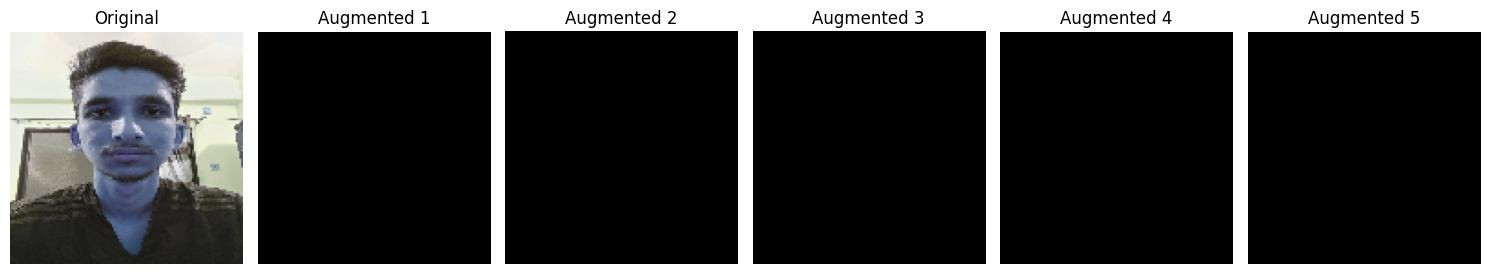

Class distribution: {np.int64(0): np.int64(4), np.int64(1): np.int64(5), np.int64(2): np.int64(5)}
Consider adding more samples or using a smaller validation_split.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,960,323 (38.00 MB)

 Trainable params: 9,958,403 (37.99 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.2727 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3636 - loss: 1.0985 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.0984 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.0983 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3636 - loss: 1.0981 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 2.0000e-04
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3636 - loss: 1.0981 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 2.0000e-04


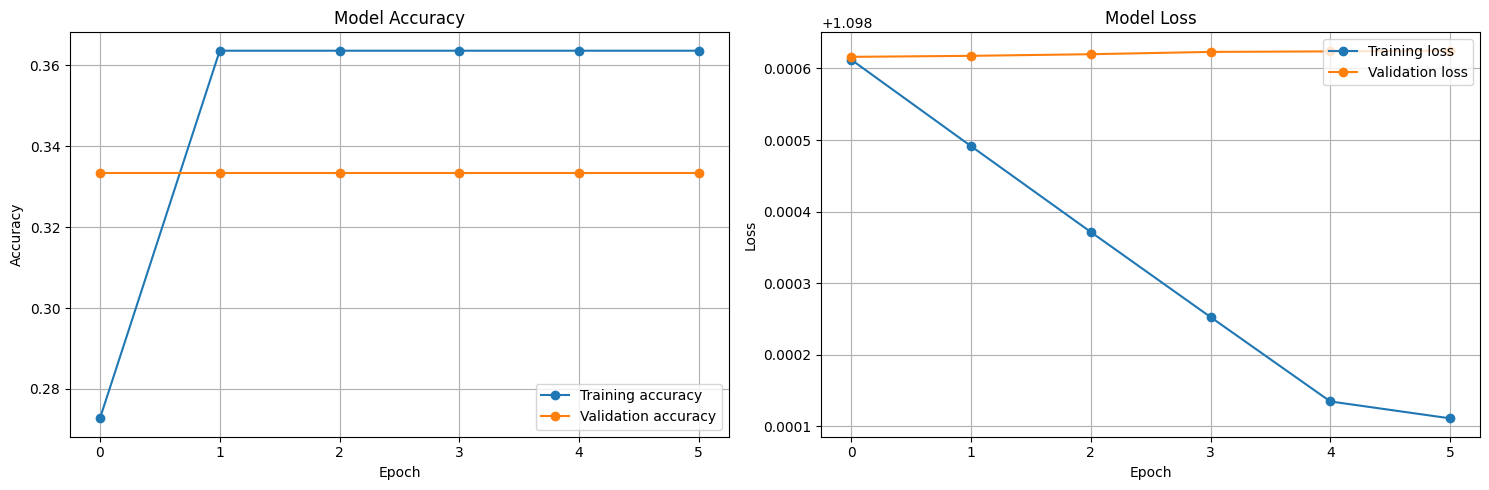

Model saved to /content/drive/My Drive/Colab Notebooks/image_classifier_model.h5
Running in Colab environment


<IPython.core.display.Javascript object>

Saved to photo.jpg


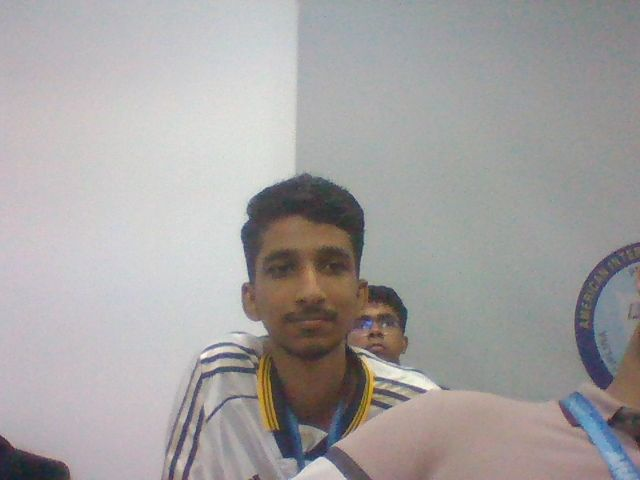

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Prediction: Rifat_khan (Confidence: 0.34)


In [11]:
def main():
    """Main execution function."""
    # Mount Google Drive
    try:
        from google.colab import drive
        drive.mount('/content/drive/')
        print("Google Drive mounted successfully")
    except ImportError:
        print("Not running in Google Colab, skipping drive mount")

    # Set data path
    data_path = "/content/drive/My Drive/Colab Notebooks/Images_dataset"

    # Initialize data processor
    data_processor = DataProcessor(data_path, img_size=(128, 128), validation_split=0.2, batch_size=32)

    # Load raw data
    x_train, y_train = data_processor.load_raw_data()

    # Visualize data augmentation examples
    data_processor.visualize_augmentations(x_train, n_images=5)

    # Create data generators with augmentation
    train_generator, validation_generator = data_processor.create_data_generators(x_train, y_train)

    # Build and train model
    model_builder = ModelBuilder(
        input_shape=(128, 128, 3),
        num_classes=len(data_processor.classes),
        learning_rate=0.001
    )

    # Build the model
    model = model_builder.build_model()
    model.summary()

    # Train the model
    history = model_builder.train_model(
        train_generator,
        validation_generator,
        epochs=20
    )

    # Visualize training metrics
    model_builder.visualize_training(history)

    # Save the model
    model_builder.save_model('/content/drive/My Drive/Colab Notebooks/image_classifier_model.h5')

    # Determine environment (Colab vs local)
    try:
        # Check if we're in Colab
        import google.colab
        in_colab = True
    except ImportError:
        in_colab = False

    # Run webcam prediction
    if in_colab:
        print("Running in Colab environment")
        run_colab_prediction(model, data_processor.classes)
    else:
        print("Running in local environment")
        run_opencv_prediction_loop(model, data_processor.classes)


if __name__ == "__main__":
    main()